# **Neural Machine Translation**

* **Aashutosh Joshi**
* **Indian Institute Of Technology, Kharagpur**

# **Import Module**

In [2]:
import warnings
warnings.filterwarnings('ignore')
import string
import re
from unicodedata import normalize
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

# **Load Model**

Code snippet below demonstrates how to load a dataset, limit the number of sentences to avoid memory issues, and split the dataset into training and testing sets.

In [3]:
#Total Sentences
total_sentences = 10000

#Load the Dataset
dataset = pd.read_csv("../input/language-translation-englishfrench/eng_-french.csv", nrows = total_sentences)

#Proportion of Test Set
test_proportion = 0.1
train_test_threshold = int( (1-test_proportion) * total_sentences)

#Print Information
printmd(f'{total_sentences} "parallel sentences" will be loaded')
printmd(f'{train_test_threshold} "parallel sentences" will be used to train the model')
printmd(f'{total_sentences-train_test_threshold} "parallel sentences" will be used to test the model')

10000 "parallel sentences" will be loaded

9000 "parallel sentences" will be used to train the model

1000 "parallel sentences" will be used to test the model

# **Data Preprocessing**

The provided code shuffles the dataset and then displays a subset of the shuffled data.
* **Shuffling**: Shuffling the dataset ensures that the training and testing data are randomly distributed. This helps in avoiding any bias that might result from the original ordering of the data.
* **Selecting a Subset**: Displaying a subset of the data after shuffling allows us to inspect a sample to ensure that the shuffling has been done correctly and to get a sense of the data's structure and content.

In [4]:
#Shuffle the Dataset
dataset = dataset.sample(frac=1, random_state=0)

#Display a Subset of the Shuffled Data
dataset.iloc[1000:1010]

,English words/sentences,French words/sentences
1554,Let me die.,Laisse-moi mourir.
2087,He's a slob.,C'est un flemmard.
5470,I have to try.,Il faut que j'essaie.
2363,I was naive.,Je fus crédule.
7570,He is bankrupt.,Il est en faillite.
6427,That's a fact.,C'est un fait.
1651,Talk to me!,Parlez-moi !
4164,Keep talking.,Continuez de parler.
1231,I broke it.,Je l'ai cassée.
9232,Tom is a judge.,Tom est juge.


The provided code defines a function clean that takes a string as input and processes it by cleaning and normalizing the text. This function is useful for preprocessing text data before feeding it into a machine learning model, ensuring that the text is in a consistent format and free of unwanted characters.

In [5]:
#Function Definition
def clean(string):
    
    #Replace No-Break Space
    string = string.replace("\u202f"," ")
    
    #Convert to Lowercase
    string = string.lower()
    
    #Delete Punctuation and Numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")
    
    #Remove Extra Spaces
    string = re.sub('\s+',' ', string)
    
    #Trim Leading and Trailing Spaces
    string = string.strip()
        
    #Return the Cleaned String
    return string

This code snippet cleans the sentences in the dataset, selects a subset of the dataset, splits it into training and testing sets, and defines the source and target languages for translation. It is preparing the data for a sequence-to-sequence machine translation model:
* Cleaning ensures the text is in a consistent format.
* Converting to a NumPy array and slicing allows easy manipulation and splitting of the dataset.
* Defining source and target languages and their indexes is crucial for further processing and model training.

In [6]:
#Clean the Sentences
dataset["English words/sentences"] = dataset["English words/sentences"].apply(lambda x: clean(x))
dataset["French words/sentences"] = dataset["French words/sentences"].apply(lambda x: clean(x))

#Select One Part of the Dataset
dataset = dataset.values
dataset = dataset[:total_sentences]

#Split into Train/Test
train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

#Define Source and Target Languages
source_str, target_str = "French", "English"

#Define the Indexes of the Source and Target
idx_src, idx_tar = 1, 0

This code snippet converts a subset of the cleaned dataset back into a Pandas DataFrame and displays it. This step helps verify that the cleaning process has been applied correctly by displaying a subset of the cleaned data. It allows us to visually inspect the results and ensure that the text has been normalized as expected.

In [7]:
#Convert Subset of Cleaned Data to DataFrame
pd.DataFrame(dataset[1000:1010])

,0,1
0,let me die,laisse moi mourir
1,he s a slob,c est un flemmard
2,i have to try,il faut que j essaie
3,i was naive,je fus crédule
4,he is bankrupt,il est en faillite
5,that s a fact,c est un fait
6,talk to me,parlez moi
7,keep talking,continuez de parler
8,i broke it,je l ai cassée
9,tom is a judge,tom est juge


The provided code defines a function **create_tokenizer** that fits a tokenizer on a list of text lines.

In [8]:
#Function Definition
def create_tokenizer(lines):
    
    #Initialize Tokenizer
    tokenizer = Tokenizer()
    
    #Fit the Tokenizer
    tokenizer.fit_on_texts(lines)
    
    #Return the Tokenizer
    return tokenizer

The provided code defines a function **max_len** that calculates the maximum sentence length in a list of text lines. Knowing the maximum sentence length is important for tasks such as padding sequences to a uniform length before feeding them into a machine learning model.

In [9]:
#Function Definition
def max_len(lines):
    
    #Calculate Maximum Sentence Length
    return max(len(line.split()) for line in lines)

The provided code defines a function **encode_sequences** that encodes and pads text sequences using a tokenizer.

In [10]:
#Function Definition
def encode_sequences(tokenizer, length, lines):
    
    #Encode Text Sequences
    X = tokenizer.texts_to_sequences(lines)
    
    #Pad Sequences
    X = pad_sequences(X, maxlen=length, padding='post')
    
    #Return the Encoded and Padded Sequences
    return X

The provided code defines a function **encode_output** that performs one-hot encoding on sequences of integers, transforming them into a format suitable for training a neural network

In [11]:
#Function Definition
def encode_output(sequences, vocab_size):
    
    #Initialize an Empty List
    ylist = list()
    
    #One-Hot Encode Each Sequence
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
        
    #Convert List to NumPy Array
    y = np.array(ylist)
    
    #Reshape the Array
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    
    #Return the One-Hot Encoded Array
    return y

The code below provided is used to prepare tokenizers for both the source and target languages, and it calculates and prints out relevant information about the vocabulary sizes and maximum sequence lengths for each language.

In [12]:
#Prepare Target Tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

#Prepare Source Tokenizer:
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')


Target (English) Vocabulary Size: 2099

Target (English) Max Length: 5


Source (French) Vocabulary Size: 4039

Source (French) Max Length: 12


The code below prepares both the training and test datasets for a sequence-to-sequence model by:
* **Encoding**: Converting sentences into sequences of integers using the tokenizers created earlier.
* **Padding**: Ensuring all sequences have the same length.
* **One-Hot Encoding**: Converting integer sequences into one-hot encoded vectors, which are necessary for models that predict a probability distribution over the vocabulary at each time step.

In [13]:
#Prepare Training Data
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

#Prepare Test Data
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)

# **Model Creation**

This model below is a classic sequence-to-sequence architecture with an encoder-decoder structure.
* **Embedding**: Converts source tokens into dense vectors.
* **Encoder LSTM**: Encodes the source sequence into a context vector.
* **RepeatVector**: Prepares the context vector to be decoded into a sequence.
* **Decoder LSTM**: Decodes the repeated context vector into a sequence of predictions.
* **TimeDistributed Dense**: Applies a dense layer to each time step to output the probabilities for each word in the target vocabulary.

In [14]:
#Function Definition
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    
    #Embedding Layer
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    
    #Encoder LSTM Layer
    model.add(LSTM(n_units))
    
    #RepeatVector Layer
    model.add(RepeatVector(tar_timesteps))
    
    #Decoder LSTM Layer
    model.add(LSTM(n_units, return_sequences=True))
    
    #TimeDistributed Dense Layer
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

The provided code creates and compiles a sequence-to-sequence model, and then visualizes the model architecture.

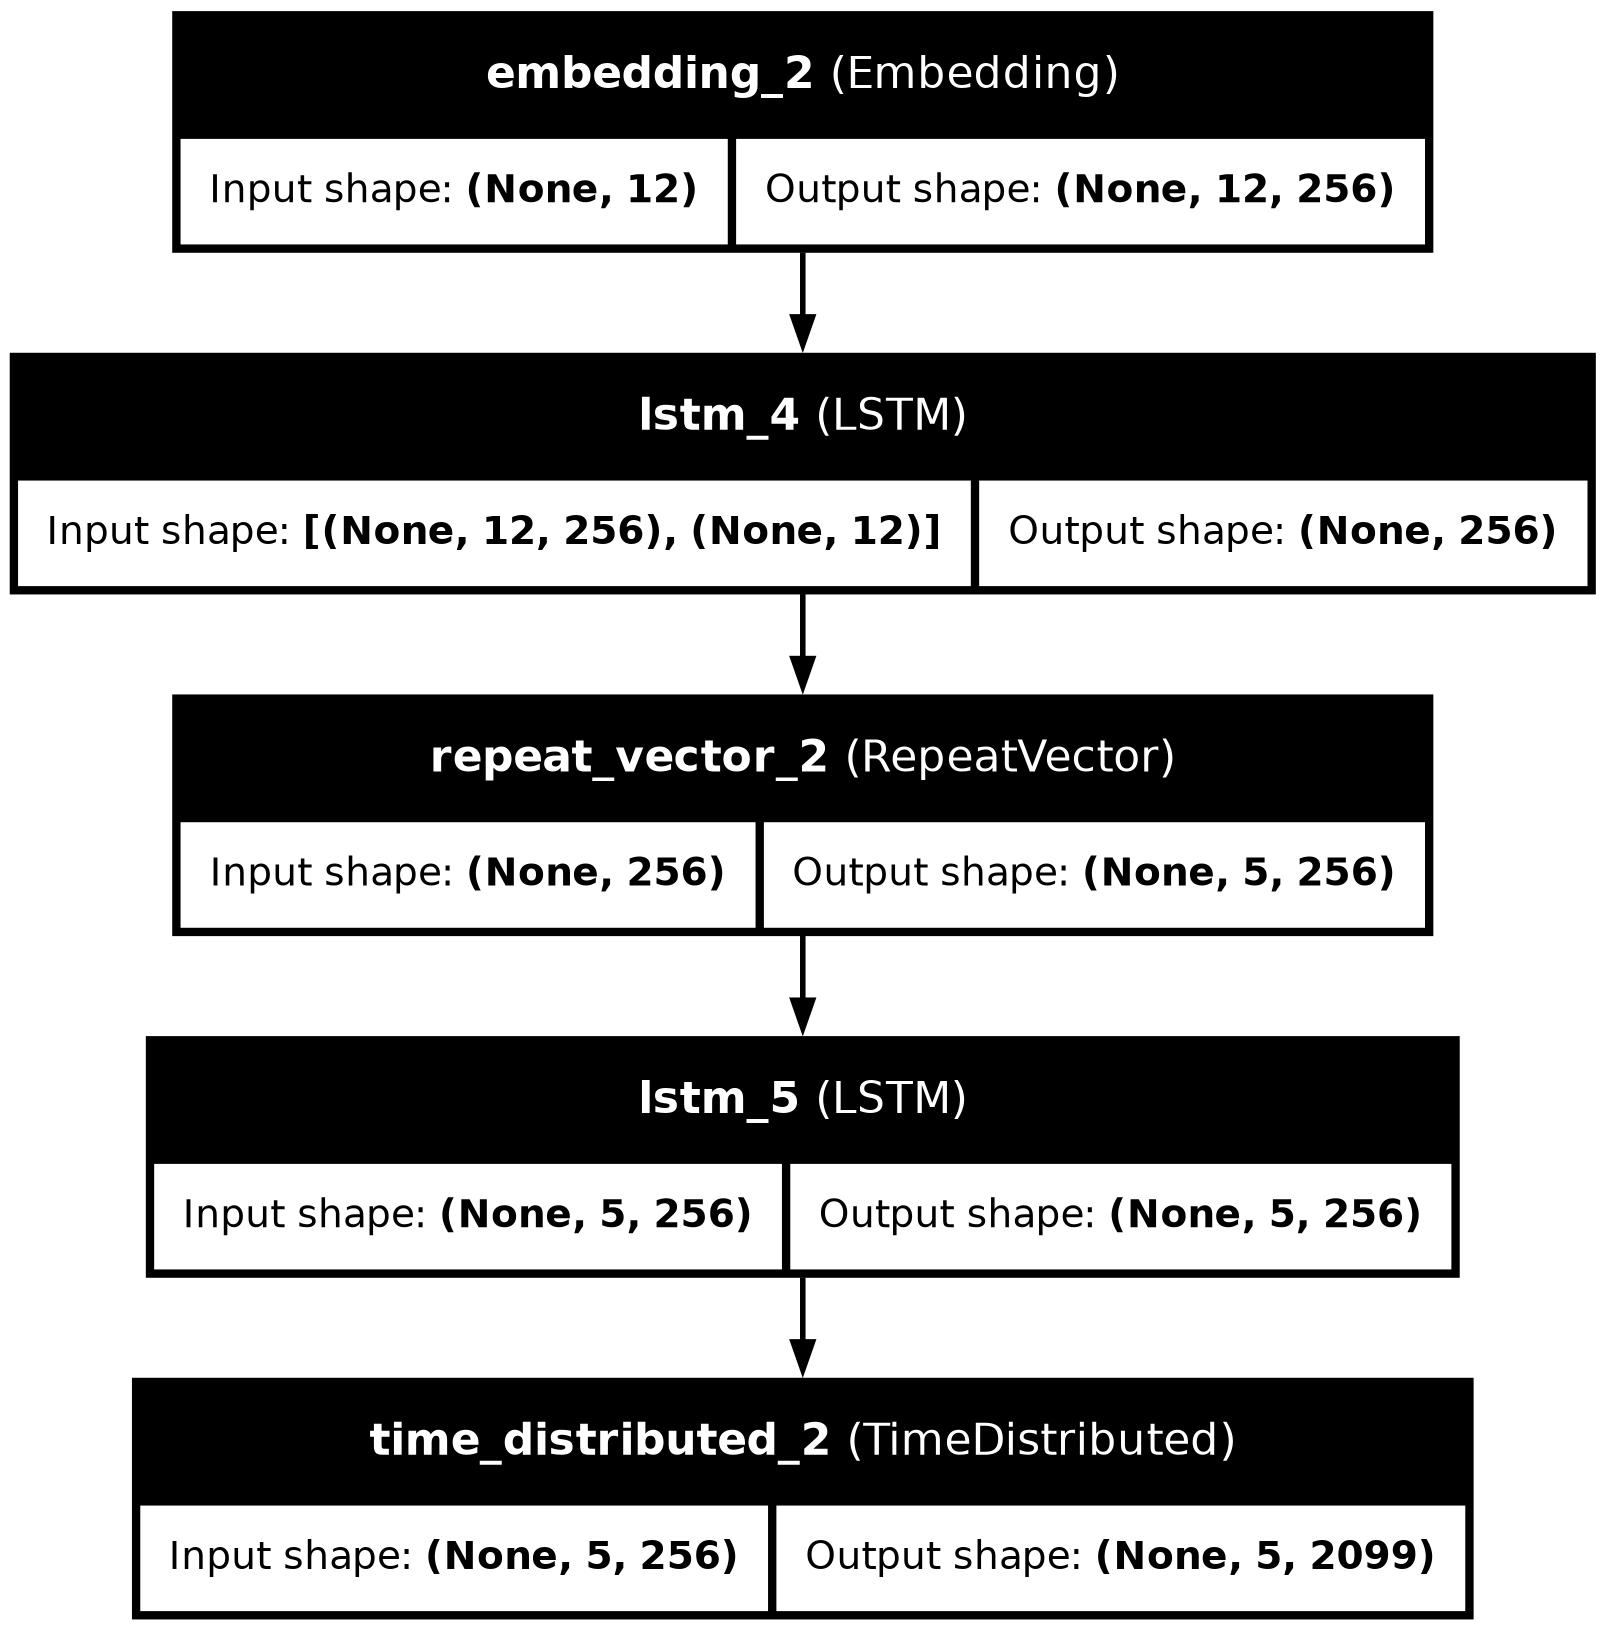

In [19]:
#Create Model
model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)

#Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy')

model.build(input_shape=(None, src_length))

#Visualize the Model Architecture
plot_model(model, show_shapes=True, show_layer_names=True)

# **Training**

The code provided trains a sequence-to-sequence model using the Keras fit method. It includes parameters for the training process and uses an EarlyStopping callback to improve training efficiency.

**Training Process:**
* The model is trained on the training data (trainX and trainY) for a maximum of 200 epochs.
* The training process uses batches of 64 samples at a time.
* 10% of the training data is used for validation, allowing you to monitor the model’s performance on a separate set of data during training.

**Early Stopping:**
* The EarlyStopping callback monitors the validation loss during training. If the validation loss does not improve for 10 epochs, training will stop early.
* This helps to prevent overfitting and ensures that the model is not trained beyond the point where it starts to overfit the training data.

In [20]:
#Model Training
history = model.fit(trainX, 
          trainY, 
          epochs=200, 
          batch_size=64, 
          validation_split=0.1, 
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )
            ])

Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 5.3592 - val_loss: 3.5567
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3859 - val_loss: 3.3466
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1471 - val_loss: 3.1456
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9515 - val_loss: 3.0099
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7868 - val_loss: 2.9146
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6690 - val_loss: 2.8338
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5319 - val_loss: 2.7112
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3827 - val_loss: 2.5938
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2403 - val_loss: 2.4990
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0819 - val_loss: 2.3919
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9673 - val_loss: 2.3219
Epoch 12/200
127/127 ━━━━━━━━━━━━━━━━━━━

The code below plots the training and validation loss over epochs during the training of a machine learning model.

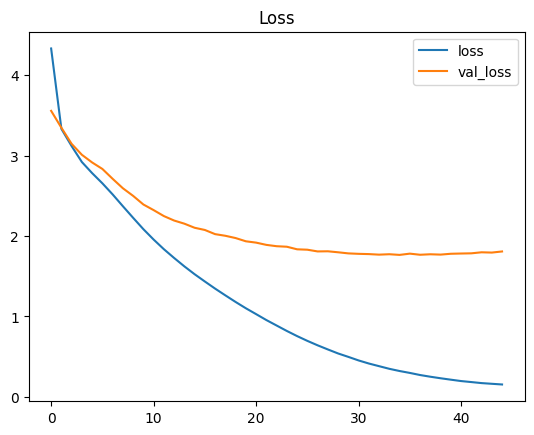

In [21]:
#Convert Training History to DataFrame
pd.DataFrame(history.history).plot()

#Set the Plot Title
plt.title("Loss")

#Display the Plot
plt.show()

# **Testing Model**

The **word_for_id** function maps an integer back to the corresponding word using the tokenizer's word index. This is useful for decoding sequences of integers (predicted by the model) back into readable text.

In [22]:
#Function Definition
def word_for_id(integer, tokenizer):
    
    #Loop Through Word Index
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
        
    #Return None if No Match
    return None

The **predict_seq** function generates a target sequence from a source sequence using a trained sequence-to-sequence model.

In [23]:
#Function Definition
def predict_seq(model, tokenizer, source):
    
    #Generate Prediction
    prediction = model.predict(source, verbose=0)[0]
    
    #Convert Prediction to Integers
    integers = [np.argmax(vector) for vector in prediction]
    
    #Decode Integers to Words
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
        
    #Return Decoded Sentence
    return ' '.join(target)

The **compare_prediction** function evaluates the performance of a sequence-to-sequence model by comparing its predictions against the actual target sentences. It prints the source sentences, actual target sentences, and the model's predicted translations side by side for a limited number of examples. 

In [24]:
#Function Definition
def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    
    #Initialization and Header Printing
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    #Iterating Through Sources
    for i, source in enumerate(sources):
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break

The provided code tests the performance of the trained sequence-to-sequence model on both the training set and the test set. It uses the **compare_prediction** function to print a comparison of the source sentence, the actual target sentence, and the model's predicted translation for a specified number of examples.

In [25]:
#Print Results on Training Set
print('### Result on the Training Set ###')
compare_prediction(model, tar_tokenizer, trainX, train)

#Print Results on Test Set
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test)

### Result on the Training Set ###
FRENCH (SOURCE)                ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

nous en savons assez           we know enough            we know enough
garde ton sang froid           stay calm                 stay calm
je ne pleurerai pas            i won t cry               i won t cry
je ne suis pas contente        i m not happy             i m not happy
moi je veux ça                 i want that               i want that
j étais tellement heureuse     i was so happy            i was so happy
j aime le printemps            i like spring             i like spring
c est mon garçon               that s my boy             that s my cat
mille mercis                   many thanks               thanks thanks lot
quelle horreur                 how horrible              how horrible
soyez satisfaites              be content                be content
toi décide                     you decide                you decide
je m en suis remis             

# **Evaluation**

The **bleu_score** function calculates the **BLEU** (Bilingual Evaluation Understudy) score for a model's translations compared to actual target sentences. BLEU score is a metric for evaluating the quality of machine-generated translations by comparing them with human-generated translations.

In [26]:
#Function Definition
def bleu_score(model, tokenizer, sources, raw_dataset):
    
    #Initialize Lists for Actual and Predicted Sentences
    actual, predicted = [], []
    
    #Iterate Through Sources and Generate Translations
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())
    
    #Calculate BLEU Scores
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    #Return BLEU Scores Dictionary
    return bleu_dic

The provided code computes the **BLEU** scores for the model's translations on both the training and test sets using the **bleu_score** function

In [27]:
#Compute BLEU Score for Training Set
bleu_train = bleu_score(model, tar_tokenizer, trainX, train)

#Compute BLEU Score for Test Set
bleu_test = bleu_score(model, tar_tokenizer, testX, test)

The provided code creates a bar chart to visualize the BLEU scores for the training set.

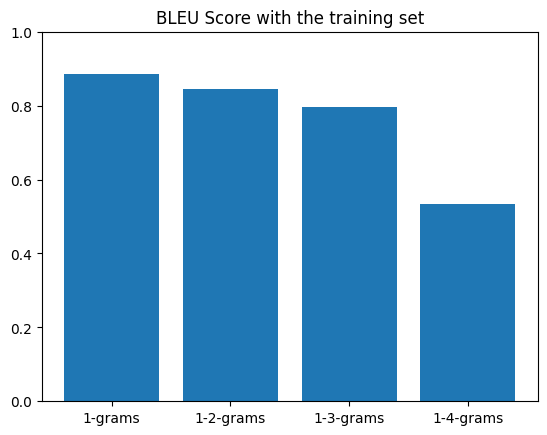

In [28]:
#Bar Chart
plt.bar(x = bleu_train.keys(), height = bleu_train.values())

#Title
plt.title("BLEU Score with the training set")

#Y-axis Limit
plt.ylim((0,1))

#Show Plot
plt.show()

This code snippet creates a bar chart to visualize the BLEU scores for the test set.

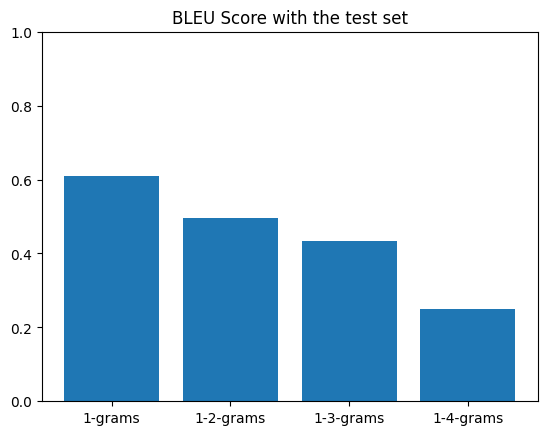

In [30]:
#Bar Chart for Test Set
plt.bar(x = bleu_test.keys(), height = bleu_test.values())

#Title for Test Set Chart
plt.title("BLEU Score with the test set")

#Y-axis Limit
plt.ylim((0,1))

#Display the Chart
plt.show()